In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [50]:
from src.data_generator import *
from src.model import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
set_plot_params()

Generate the training data, initially consider a very simple case of constant volatility, to use as a benchmark to test the methods.

In [72]:
N_paths = 100000
total_timesteps = 60*60*7.5 #1 second data
n_timesteps = 60 #train at 1 minute interval

X = SemiMartingale(X_0=1.0, vol='expou', theta=2.0, beta=0.5)
x = X.generate(N_paths, total_timesteps, n_timesteps)
x = np.expand_dims(x, -1)

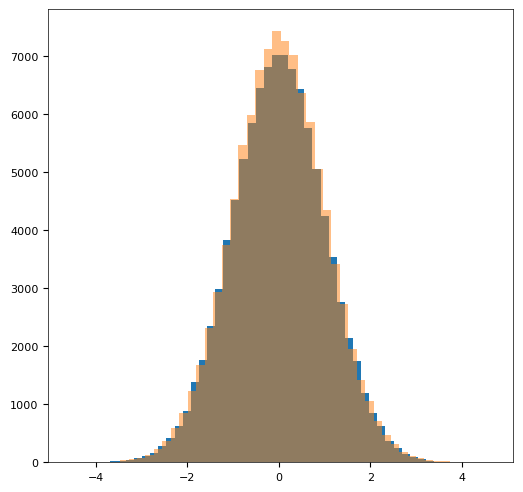

In [69]:
plt.hist(X.get_norm_increments(), bins=50)
plt.hist(np.random.normal(size=100000), alpha=0.5, bins=50)
plt.show()

First train a model using a method of moments. We try to match the first $k$ moments of the distribution generated by 
$$
Z_F = \frac{X_1 - X_0}{\sqrt{F(X_0,X_{1/n},X_{2/n},\ldots,X_{(n-1)/n},X_1)}}
$$
to those of the standard normal. We set $k=4$ and train using the $L1$ norm. We use a simple feedforward neural network, and train for 10 epochs.

# Model 3: Using RBF MMD

In [73]:
rbfmmd_loss = RBFMMDLoss(length_scale=1.0)
rbfmmd_model = RNNNetwork(n_layers=2, h_dims=32, loss=rbfmmd_loss)

In [ ]:
history = rbfmmd_model.train(x, num_epochs=10, batch_size=256, plotting=False, lr=0.00001)

In [39]:
iv = rbfmmd_model.predict_iv(x_test)

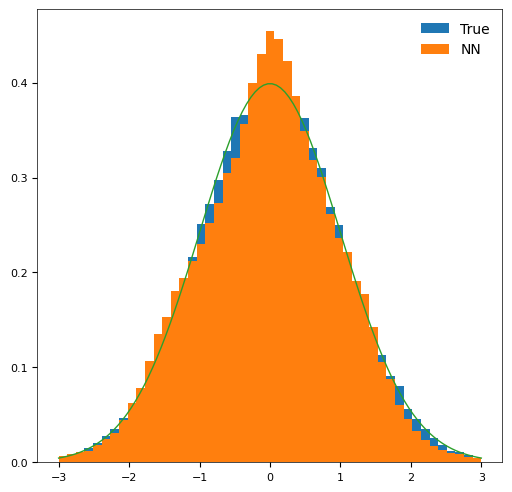

In [40]:
plot_hist(x_test, iv, X.get_norm_increments(), n_bins=50)

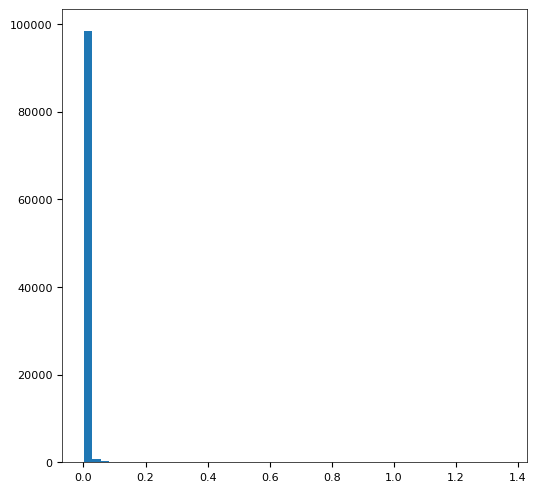

In [41]:
plt.hist(iv, bins=50)
plt.show()

In [44]:
model_z = rbfmmd_model.predict_z(x_test)
kstest(model_z, 'norm')

KstestResult(statistic=0.01418956188404441, pvalue=6.4222775017376174e-18)

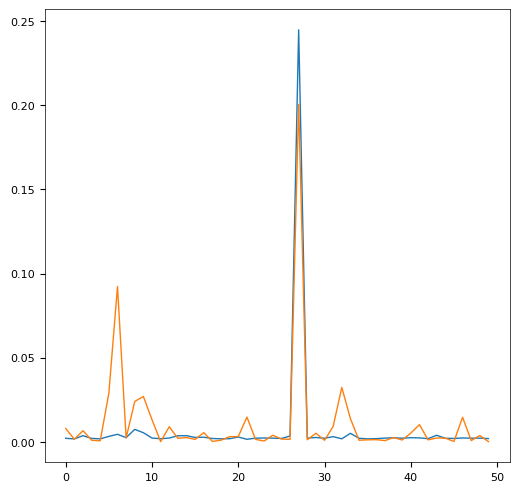

In [49]:
plt.plot(iv[:50])
plt.plot(X.integrated_variance()[:50])

array([0.00794031, 0.00154377, 0.00666154, ..., 0.03099195, 0.00224252,
       0.00122491])

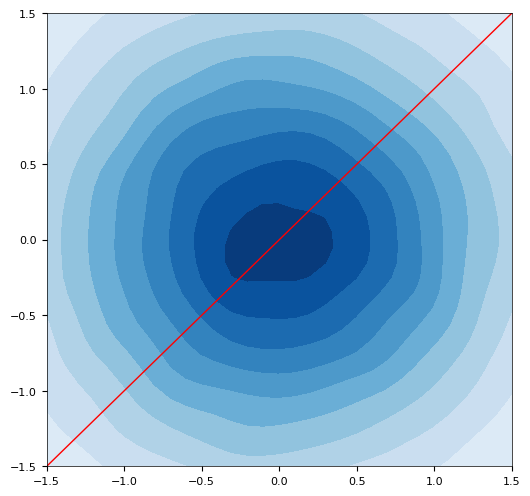

In [58]:
sns.kdeplot(model_z, X.get_norm_increments(), cmap="Blues", shade=True, shade_lowest=True)
plt.plot((-2,2),(-2,2), color='red')
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
plt.show()

In [59]:
print(f'True IV: {X.integrated_variance().mean():.4f}')
print(f'Median estimate: {np.median(iv):.4f}, Mean estimate: {np.mean(iv):.4f}, std dev of estimates: {np.std(iv):.4f}')

True IV: 0.0089
Median estimate: 0.0089, Mean estimate: 0.0090, std dev of estimates: 0.0012
